In [426]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [448]:
# Ignore sklearn's pesky warnings

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## (a)

In [329]:
# Define soft thresholding function

def soft_thresh(x, y, lambda_):
    if x*y > lambda_:
        return (x*y-lambda_)/x**2
    elif x*y < -lambda_:
        return (x*y+lambda_)/x**2
    return 0

In [330]:
# Define simplified case of objective function

def simple_obj(beta, x, y, lambda_):
    return 1/2*(y-x*beta)**2+lambda_*np.absolute(beta)

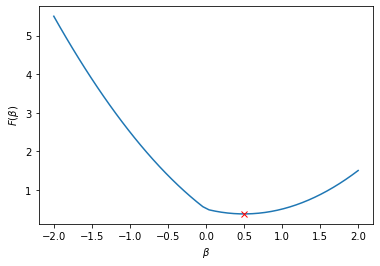

In [331]:
# Plot objective function and analytically-obtained minimum

betas = np.linspace(-2, 2, 50)
x = 1
y = 1
lambda_ = .5

points = []
for beta in betas:
    points.append(simple_obj(beta, x, y, lambda_))

beta_min = soft_thresh(x, y, lambda_)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$F(\beta)$')
plt.plot(betas, points)
plt.plot(beta_min, simple_obj(beta_min, x, y, lambda_), 'rx')

## (b)

In [390]:
# Define objective function for the general case

def compute_obj(beta, X, y, lambda_):
    n = len(y)
    x_b = np.dot(X, beta)
    return 1/(2*n)*np.dot(np.transpose(y-x_b), y-x_b)+lambda_*np.linalg.norm(beta, ord=1)

In [391]:
# generate data

np.random.seed(123)
X = np.random.normal(size=(10, 2))
beta = np.array([2.0, -5.0])
y = np.dot(X, beta) + np.random.normal(10)
lam = 3.0

In [392]:
def plot_objective(X, y, compute_obj, lambda_, init_beta=None, min_beta=None, iterates=None, labels=False):
    nb = 100
    brange = np.linspace(-10, 10, nb)
    b1, b2 = np.meshgrid(brange, brange)
    z = np.array([compute_obj(beta, X, y, lambda_) for
                  beta in zip(b1.ravel(), b2.ravel())])
    levels=np.logspace(-5,4,100)
    plt.figure(figsize=(6,6))
    plt.hlines(y=0, xmin=-10, xmax=10, color='k')
    plt.vlines(x=0, ymin=-10, ymax=10, color='k')
    if init_beta is not None:
        plt.scatter(init_beta[0], init_beta[1], marker="x", s=100, color='k', label="init point")
    if min_beta is not None:
        plt.scatter(min_beta[0], min_beta[1], marker="x", s=100, color='r', label="after partial min")
    if iterates is not None:
        # Arrows.
        for j in range(1, len(iterates)):
            plt.annotate("",xy=iterates[j],xytext=iterates[j - 1],
                         arrowprops={"arrowstyle": "->", "color": color, "lw": 1},
                         va="center",ha="center",)
    if labels:
        plt.legend(loc="upper right")
    plt.contour(brange, brange, z.reshape((nb, nb)), levels=levels)
    plt.show()

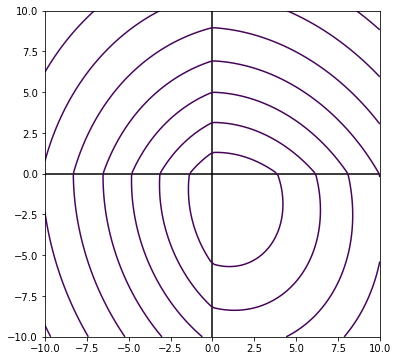

In [393]:
# Produce contour plot of objective function

plot_objective(X, y, compute_obj, lam)

## (c)

In [397]:
# Define partial minimization function

def partial_min(beta, X, y, lambda_, j):
    n = len(y)
    beta_partial_opt = np.copy(beta)
    Xj = X[:, j]
    Xnj = np.hstack((X[:, :j], X[:, (j+1):]))
    bnj = np.concatenate((beta_partial_opt[:j], beta_partial_opt[j+1:]))
    rj = y-np.dot(Xnj, bnj)
    zj = np.linalg.norm(Xj, ord=2)**2
    prod = 1/n*np.dot(Xj.T, rj)
    if prod <= -lambda_:
        beta_partial_opt[j] = (lambda_+prod)/(2/n*zj)
    elif prod >= lambda_:
        beta_partial_opt[j] = (-lambda_+prod)/(2/n*zj)
    else: # |prod| <= lambda
        beta_partial_opt[j] = 0
    return beta_partial_opt

In [398]:
# Initialize params

beta_init = np.array([5.0, 5.0])
j = 1

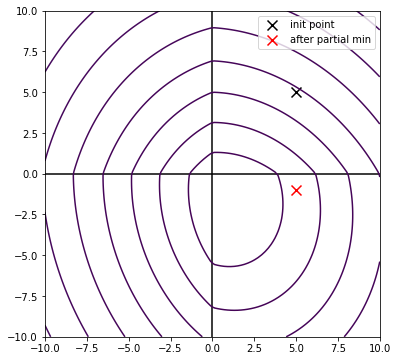

In [399]:
# Produce contour plot of objective function w/ a single interation of partial minimization

beta_min = partial_min(beta_init, X, y, lam, j)
plot_objective(X, y, compute_obj, lam, init_beta=beta_init, min_beta=beta_min, labels=True)

## (d)

In [343]:
# Load dataset, print head

super_con = pd.read_csv('HW4_data.csv')
super_con.head()

mean_atomic_mass  wtd_mean_atomic_mass  gmean_atomic_mass  \
0         84.231574             57.842763          66.164102   
1         88.944468             57.894262          66.361592   
2         75.100250             51.579798          61.298642   
3         74.231650             51.480943          60.515221   
4        119.942725             91.077409          90.003794   

   wtd_gmean_atomic_mass  entropy_atomic_mass  wtd_entropy_atomic_mass  \
0              36.112184             1.430024                 1.138253   
1              36.124868             1.181795                 0.932518   
2              35.158873             1.456708                 1.390133   
3              35.113886             1.453747                 1.340115   
4              73.231604             1.590565                 1.551095   

   range_atomic_mass  wtd_range_atomic_mass  std_atomic_mass  \
0          122.90607              33.640786        47.428396   
1          122.90607              37.319570        51.968828   
2          121.32760              19.623906        39.288902   
3          121.32760              20.650805        39.445875   
4          191.20060              29.007229        70.961415   

   wtd_std_atomic_mass  ...  wtd_mean_fie   gmean_fie  wtd_gmean_fie  \
0            53.589094  ...   1009.946857  752.280835     937.287219   
1            53.669752  ...   1011.040571  718.152900     939.406232   
2            44.284202  ...    998.089172  705.732671     930.382127   
3            44.246346  ...   1003.200310  771.891022     937.305449   
4            55.280514  ...    721.865714  701.448928     687.113728   

   entropy_fie  wtd_entropy_fie  range_fie  wtd_range_fie     std_fie  \
0     1.545214         0.812484      810.6     749.048857  294.283693   
1     1.305967         0.764604      810.6     746.035714  323.811808   
2     1.542128         0.937941      810.6     690.345940  291.828474   
3     1.552506         0.929772      810.6     694.888235  282.395259   
4     1.733547         1.540374      786.5     192.422857  268.928309   

   wtd_std_fie  critical_temp  
0   356.200361            5.0  
1   354.499974           10.2  
2   346.349554           75.0  
3   341.811885           53.0  
4   255.944162           90.0  

[5 rows x 21 columns]

In [470]:
# Split data into training and test sets, standardize X, center y

response = 'critical_temp'
features = [name for name in super_con.columns.values if name != response]

y = np.array(super_con[response])
X = np.array(super_con[features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler_X = StandardScaler().fit(X_train)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))
y_train = scaler_y.transform(y_train.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

## (e)

In [471]:
# Calculate and print optimal lambda using 5-fold CV

alphas = np.logspace(-2,2,31)
lambda_5_CV = LassoCV(cv=5, alphas=alphas, max_iter=1000000).fit(X_train, y_train).alpha_
print('Optimal lambda using 5-fold CV:', lambda_5_CV)

Optimal lambda using 5-fold CV: 0.025118864315095794


In [472]:
# Calculate and print optimal lambda using Leave One Out CV

lambda_LOO_CV = LassoCV(cv=len(y_train)-1, alphas=alphas, max_iter=1000000).fit(X_train, y_train).alpha_
print('Optimal lambda using Leave-One-Out CV:', lambda_LOO_CV)

Optimal lambda using Leave-One-Out CV: 0.018478497974222907


## (f), (g)

In [473]:
# Re-define partial minimization function to match sklearn's implementation

def partial_min_sk(beta, X, y, lambda_, j):
    n = len(y)
    beta_partial_opt = np.copy(beta)
    Xj = X[:, j]
    Xnj = np.hstack((X[:, :j], X[:, (j+1):]))
    bnj = np.concatenate((beta_partial_opt[:j], beta_partial_opt[j+1:]))
    rj = y-np.dot(Xnj, bnj)
    zj = np.linalg.norm(Xj, ord=2)**2
    prod = 1/n*np.dot(Xj.T, rj)
    if prod < -lambda_:
        beta_partial_opt[j] = (lambda_+prod)/(1/n*zj)
    elif prod > lambda_:
        beta_partial_opt[j] = (-lambda_+prod)/(1/n*zj)
    else: # |prod| <= lambda
        beta_partial_opt[j] = 0
    return beta_partial_opt

In [474]:
# Define Coordinate Descent Algorithm (either cyclic or random depending on value of 'random')

def coord_descent(X, y, lambda_, partial_min, max_iter, random=False):
    d = X.shape[1]
    beta = np.zeros(d)
    iterates = []
    for i in range(max_iter):
        if random:
            j = np.random.choice(d)
        else:
            j = i % d
        beta_temp = partial_min(beta, X, y, lambda_, j)
        beta = beta_temp
        iterates.append(beta)
    return iterates

## (h)

In [475]:
# Obtain iterates for the random/cyclic implementations of the algorithm over 20000 iterations using lambda=3

max_iter = 20000
cyclic_iterates = coord_descent(X_train, y_train, lam, partial_min_sk, max_iter)
random_iterates = coord_descent(X_train, y_train, lam, partial_min_sk, max_iter, random=True)

In [476]:
# Obtain objective function values for each beta in each set of iterates

cyclic_points = []
random_points = []
for i in range(max_iter):
    cyclic_points.append(compute_obj(cyclic_iterates[i], X_train, y_train, lam))
    random_points.append(compute_obj(random_iterates[i], X_train, y_train, lam))

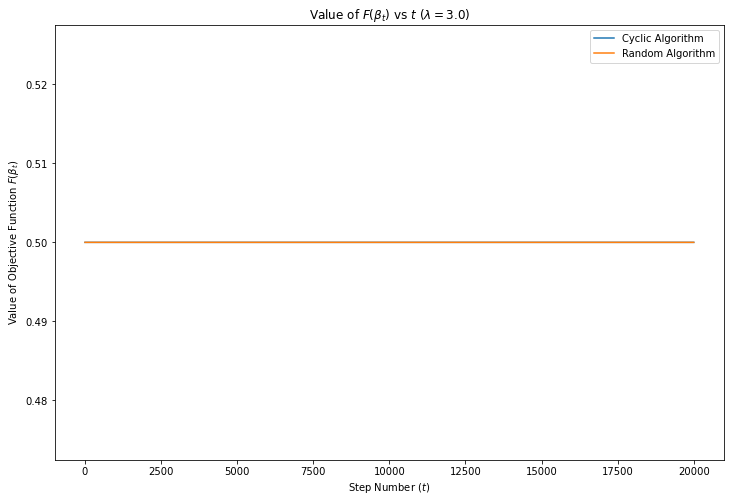

In [477]:
# Plot both algorithm's objective function value vs algorithm step number

f = plt.figure(figsize = (12,8))
plt.xlabel('Step Number ($t$)')
plt.ylabel(r'Value of Objective Function $F(\beta_t)$')
plt.title(r'Value of $F(\beta_t)$ vs $t$ ($\lambda=3.0$)')
plt.plot(cyclic_points)
plt.plot(random_points)
plt.legend(['Cyclic Algorithm', 'Random Algorithm'])

As can be seen above, with this high of a penalization value the objective function appears to be flat and cannot be minimized. 

## (i)

In [478]:
# Obtain iterates for the random/cyclic implementations of the algorithm over 20000 iterations

max_iter = 20000
cyclic_iterates = coord_descent(X_train, y_train, lambda_5_CV, partial_min_sk, max_iter)
random_iterates = coord_descent(X_train, y_train, lambda_5_CV, partial_min_sk, max_iter, random=True)

In [479]:
cyclic_points = []
random_points = []
for i in range(max_iter):
    cyclic_points.append(compute_obj(cyclic_iterates[i], X_train, y_train, lambda_5_CV))
    random_points.append(compute_obj(random_iterates[i], X_train, y_train, lambda_5_CV))

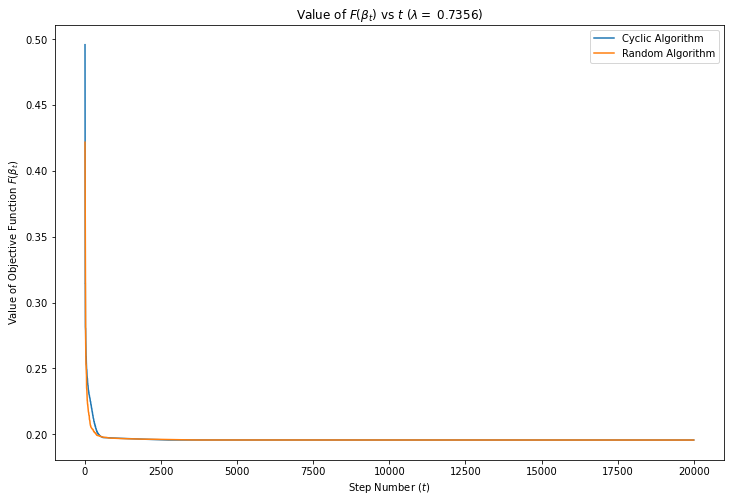

In [480]:
# Plot both algorithm's objective function value vs algorithm step number

f = plt.figure(figsize = (12,8))
plt.xlabel('Step Number ($t$)')
plt.ylabel(r'Value of Objective Function $F(\beta_t)$')
plt.title(r'Value of $F(\beta_t)$ vs $t$ ($\lambda=~0.7356$)')
plt.plot(cyclic_points)
plt.plot(random_points)
plt.legend(['Cyclic Algorithm', 'Random Algorithm'])

## (j)

In [481]:
beta_sk = Lasso(alpha=lambda_5_CV, max_iter=max_iter).fit(X_train, y_train).coef_

print('Coefficients from Trevor\'s cyclic implementation:\n', cyclic_iterates[-1])
print('\nCoefficients from Trevor\'s random implementation:\n', random_iterates[-1])
print('\nCoefficients from sklearn\'s implementation:\n', beta_sk)

Coefficients from Trevor's cyclic implementation:
 [ 0.          0.         -0.48121182  0.          0.          0.
  0.         -0.27906757  0.49187005  0.          0.          0.
  0.         -0.57422591  0.          0.          0.04481249  0.
  0.          0.        ]

Coefficients from Trevor's random implementation:
 [ 0.          0.         -0.48121182  0.          0.          0.
  0.         -0.27906757  0.49187005  0.          0.          0.
  0.         -0.57422591  0.          0.          0.04481249  0.
  0.          0.        ]

Coefficients from sklearn's implementation:
 [-0.         -0.         -0.48120651 -0.         -0.          0.
  0.         -0.2790689   0.49187037  0.          0.         -0.
  0.         -0.57422485  0.          0.          0.04481417 -0.
 -0.         -0.        ]


As can be seen above, the final iterates of both implementations are quite close to the value obtained by sci-kit learn!

## (k)

In [482]:
print('Features selected by Trevor\'s Lasso:\n')
print(list(compress(features, random_iterates[-1] != 0)))

Features selected by Trevor's Lasso:

['gmean_atomic_mass', 'wtd_range_atomic_mass', 'std_atomic_mass', 'wtd_gmean_fie', 'range_fie']


As expected, the final iterate of the Lasso Regression was very sparse, having non-zero values for only 5 out of the 20 total features. 

## (l)

In [483]:
def compute_ridge_reg_path(X, y, lam_range, sk=False):
    coefs = []
    for lam in lam_range:
        if sk:
            coefs.append(Lasso(alpha=lam, max_iter=20000).fit(X, y).coef_) 
        else:
            coefs.append(coord_descent(X, y, lam, partial_min_sk, max_iter=20000, random=True)[-1]) 
    return np.array(coefs)

def plot_reg_path(coefs, lam_range):
    f = plt.figure(figsize = (12,8))
    d = coefs.shape[1]
    for j in range(d):
        log_decreasing_lams = np.log(lam_range)[::-1]
        plt.plot(np.log(lam_range), coefs[:,j], label='Component {}'.format(j))
        
    plt.gca().invert_xaxis() # plot w/ lambda decreasing from left to right
    plt.xlabel(r'$\log \lambda$')
    plt.ylabel('Ridge parameter')
    plt.legend(frameon=False, loc='upper left', fontsize=10)
    plt.show()

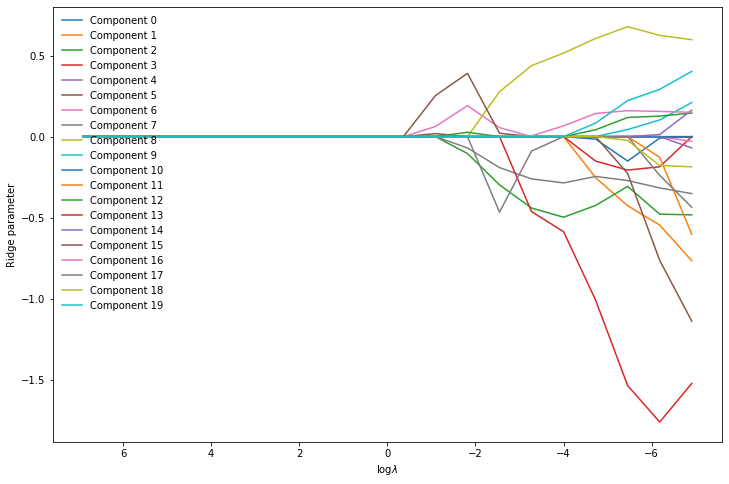

In [484]:
# Specify lambda range, calculate coefficients using my implementation, plot resulting regularization path

lam_range = np.logspace(-3,3,20)
params = compute_ridge_reg_path(X_train, y_train, lam_range)
plot_reg_path(params, lam_range)

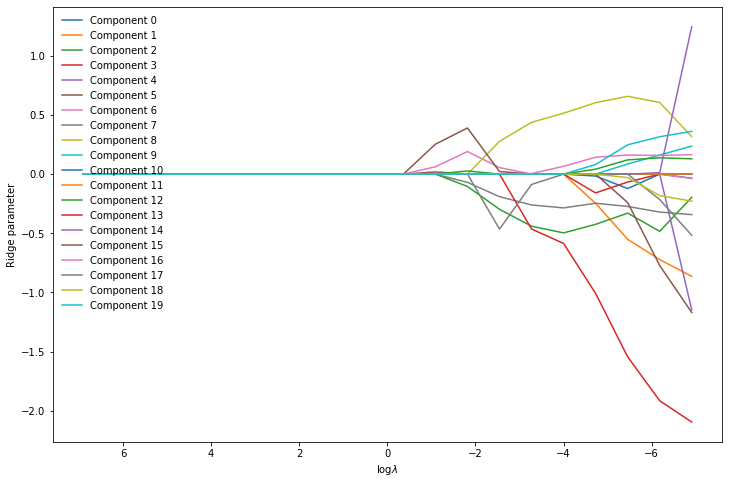

In [485]:
# Plot the same for sklearn's implementation

params = compute_ridge_reg_path(X_train, y_train, lam_range, sk=True)
plot_reg_path(params, lam_range)

Despite being rather chaotic, the regularization paths for both my implementation (fist plot) and sklearn's (second plot) are quite similar. Initially, all coefficients are zero due to the high penalization value. As this value shrinks, however, the coefficients become unconstrained and take on a large assortment of values, ultimately ending at something close to the optimal solution for simple linear regression.